# End to End Reinforcement Learning

In this tutorial, you will learn how to train a simple Actor Critic Model using TorchRL. We will explore different optimizaions for a single agent setup, and train a simple agent to complete MountainCar-v0.  

In [1]:
!pip install torchrl==0.7.0 gymnasium==0.29 tqdm matplotlib av tensordict==0.7.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

### Dependencies and Setup

The code below imports all libraries needed for TorchRL to work. TorchRL is more modular compared to other libraries, leading us to need to import many different moving parts in order to train an agent. However, the benefit becomes it is much easier to extend our agent and customise it, as opposed to other frameworks like Stable Baseline 3 and Tianshou


NOTE: Google Colab prompts for changes whenever the numpy version is changed, so just restart your session and all should be fixed.

In [2]:
from pathlib import Path
from IPython.display import Video
import os

# https://gymnasium.farama.org/
'''DO NOT ACCIDENTALLY INSTALL OPENAI GYM, IT IS OUTDATED'''
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# Port environment into TorchRL
from torchrl.envs import GymWrapper
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch

from tensordict.nn import TensorDictModule
from torch import nn
from torch.distributions import Categorical

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose, DoubleToFloat,
    ObservationNorm, StepCounter,
    TransformedEnv
)
from torchrl.envs.transforms import Transform
from torchrl.envs import ParallelEnv, EnvCreator, SerialEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm.notebook import tqdm
from torchrl.record import VideoRecorder
from torchrl.record.loggers import CSVLogger

### Creating the environment

We choose to create the MountainCar-v0 environment, where the goal is to train an agent to reach the top of the right hill.

Unlike in the previous tutorial, we set up our environment slightly differently: We are using a lambda object instead of just feeding TransformedEnv directly.

We will explore more on why so in later cells.

In [3]:
## Reward Shaping - To ensure we get somewhat better performance (You can tweak this to give better results!)

class VelocityPositionReward(Transform):
    def __init__(self, velocity_weight=5.0, position_threshold=0.0, side_bonus_weight=2.0, base_reward=0.0):
        super().__init__()
        self.velocity_weight = velocity_weight
        self.side_bonus_weight = side_bonus_weight
        self.position_threshold = position_threshold  # Threshold to determine left vs right side
        self.base_reward = base_reward
        self.max_velocity = None
        self.min_velocity = None

    def _step(self, tensordict, next_tensordict):
        # Extract velocity and position from the next observation
        velocity = next_tensordict["observation"][..., 1]
        position = next_tensordict["observation"][..., 0]  # Assuming position is at index 0

        # Initialize velocity trackers for new episodes if needed
        if self.max_velocity is None or self.min_velocity is None or next_tensordict.get("done", False).any():
            self.max_velocity = velocity.clone()
            self.min_velocity = velocity.clone()

        # Update max_velocity when a new maximum is reached
        self.max_velocity = torch.maximum(velocity, self.max_velocity)

        # Update min_velocity when a new minimum is reached
        self.min_velocity = torch.minimum(velocity, self.min_velocity)

        # Start with base reward + velocity component (as in original)
        reward = self.base_reward + self.velocity_weight * self.max_velocity

        # Apply position-based velocity bonus
        left_side = position < self.position_threshold
        right_side = position >= self.position_threshold

        # For left side positions, bonus for negative velocity (going left)
        left_bonus = torch.where(
            left_side & (velocity < 0),
            self.side_bonus_weight * torch.abs(self.min_velocity),
            torch.zeros_like(velocity)
        )

        # For right side positions, bonus for positive velocity (going right)
        right_bonus = torch.where(
            right_side & (velocity > 0),
            self.side_bonus_weight * self.max_velocity,
            torch.zeros_like(velocity)
        )

        # Add the bonuses to the reward
        reward = reward + left_bonus + right_bonus

        # Update the reward in the next_tensordict
        next_tensordict.set("reward", reward.unsqueeze(-1))

        return next_tensordict

    def _reset(self, tensordict, tensordict_reset):
        # Reset the velocity tracking
        self.max_velocity = None
        self.min_velocity = None
        return tensordict_reset

In [4]:
HOME_DIR = Path("/working")
os.makedirs(HOME_DIR, exist_ok = True)
RANDOM_SEED = 42
DEVICE = 'cpu'
OUTPUT_DIR = Path("./working")
OUTPUT_DIR.mkdir(exist_ok=True)
VIDEO_DIR = OUTPUT_DIR / "my_exp" / "videos"

'''
How to make an environment in TorchRL

env = gym.make("MountainCar-v0", render_mode = "rgb_array")
base_env = GymWrapper(env, device = DEVICE, categorical_action_encoding=False) #Change this to false as we use OneHot
'''

logger = CSVLogger(exp_name="my_exp", log_dir = OUTPUT_DIR, video_format="mp4")

# 1) Factory for the recording env (worker 0)
def make_nonrecording_env():
    base = GymWrapper(
        gym.make("MountainCar-v0"),
        device="cpu",
        categorical_action_encoding=True,
    )
    return TransformedEnv(
        base,
        Compose(
            DoubleToFloat(),
            VelocityPositionReward(),
            StepCounter(),

        ),
    )


#Build a **serial** env with the recorder
base = GymWrapper(
    gym.make("MountainCar-v0", render_mode="rgb_array"),
    device=DEVICE,
    categorical_action_encoding=True,
    from_pixels=True,
    pixels_only=False,
)
rec_env = TransformedEnv(
    base,
    Compose(
        DoubleToFloat(),
        VideoRecorder(logger, tag="only_video", skip=5),
        VelocityPositionReward(),
        StepCounter(),

    ),
)


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

### Hyperparameters

These values change the complexity of the neurual network and other variables when training, such as batch size, total number of frames per episode,  replay buffer batches etc.


In [5]:

# Optimization Hyperparameters

num_cells = 64  # number of cells in each hidden layer
lr = 3e-4
max_grad_norm = 1.0

# Collection Hyperparams

# How many frames to simulate the environment with the current policy
# before you start optimizing your policy
frames_per_batch = 2000

# After this number of frames, stop training.
# For serious training endeavors, do at least 1M steps.
total_frames = 250_000

# Algorithm Hyperparameters

# In Supervised Learning, this is your Batch Size.
# Here we are referring to a small slice of the frames we collected above.
# This is passed wholesale into the policy for backpropagation.
sub_batch_size = 64

# How many times you want to loop through the collected frames
# during your optimization phase.
# This is PPO-specific, other algorithms
num_epochs = 10

# clip value for PPO loss: see the equation in the intro for more context.
clip_epsilon = (
    0.2
)
# Gamma and Lambda are hyperparameters for Generalised Advantage Estimation.
# This is specific to most modern implementations of PPO,
# and the math is very complex (the interested can go look at https://datascience.stackexchange.com/questions/32480/how-does-generalised-advantage-estimation-work),
# but if you are just looking to optimize the algorithm:
# 1. Gamma controls to what extent your algorithm looks into the future.
# Specifically, steps into the future ~= 1 / (1 - gamma)
# 2. Lambda
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

### Parallel Environments

If you had run the previous code for testing in Unit 1.1, the code would have taken a very long time to train a baseline PPO model. That is because simulating the agent on the environment is very compute intensive. By trading off memory usage, we can create multiple environments in parallel to speed up training.

To do this, we call ParallelEnv, and feed it a lambda that creates a new environment. We also provide the number of environments we would like to provide in parallel.

Due to constraints in the Colab instance provided, we have reduced the number of parallel environments to 2. Do feel free to try and optimise the code to allow for larger parallel runs if you are interested!

In [6]:

composed_env = ParallelEnv(3, make_nonrecording_env) #Parallel env makes it faster

''' print("observation_spec:", composed_env.observation_spec)
print("reward_spec:", composed_env.reward_spec)
print("input_spec:", composed_env.input_spec)
print("action_spec (as defined by input_spec):", composed_env.action_spec)

assert composed_env.batch_size == (2,) '''

check_env_specs(composed_env)
check_env_specs(rec_env)

2025-05-06 06:55:00,027 [torchrl][INFO] check_env_specs succeeded!
2025-05-06 06:55:00,177 [torchrl][INFO] check_env_specs succeeded!


### Actor Critic:
Over here we set up a simple Actor Critic pipeline to learn how to solve MountainCar-v0.

The actor critic pipeline can be summed into
1. Define the policy for the actor
1. Create the actor with ProbabilisticActor
1. Create the critic module.



We use LazyLinear, which is an abstraction on nn.Linear, but it ignores the input shape, allowing us to focus on the architecture rather than also focus on ensuring the tensor shapes fit at every step of the implementation.

This will culminate in us eventually having to solve the shape errors if any during the training loop/rollouts with the policy, but saves us a lot of time and mental energy from dealing with the other moving parts in RL.



In [7]:
# Simple Actor-Critic Setup

# You can skip these if you want, these are the underlying neural networks.
# Since we are using a Discrete policy, we need to use a Softmax to transform the outputs into action probabilities.
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(composed_env.action_spec.shape[-1], device = DEVICE),
    nn.Softmax()
)

print(composed_env.action_spec.shape[-1])

value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(1, device=DEVICE),
)


# Actor Module
policy_module = ProbabilisticActor(
    module = TensorDictModule(
        actor_net, in_keys=["observation"], out_keys=["logits"]
    ),
    spec=composed_env.action_spec,
    in_keys=["logits"],
    distribution_class=Categorical,
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

# Critic Module
value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

3


/usr/local/lib/python3.11/dist-packages/tensordict/nn/probabilistic.py:460: DeprecationWarning: You are querying the log-probability key of a SafeProbabilisticModule where the composite_lp_aggregate has not been set and the log-prob key has not been chosen. Currently, it is assumed that composite_lp_aggregate() will return True: the log-probs will be aggregated in a sample_log_prob entry. From v0.9, this behaviour will be changed and individual log-probs will be written in `('path', 'to', 'leaf', '<sample_name>_log_prob')`. To prepare for this change, call `set_composite_lp_aggregate(mode: bool).set()` at the beginning of your script (or set the COMPOSITE_LP_AGGREGATE env variable). Use mode=True to keep the current behaviour, and mode=False to use per-leaf log-probs.
  warnings.warn(


In [8]:
# Here's some code that shows how you can shape-check your TensorDicts.

# Source TensorDict
td = composed_env.reset()
print(td)

# You should notice, at least for this problem, that we have 3 new keys: `action`, `logits`, `sample_log_prob`
# By doing so, TorchRL allows you to examine each step of your rollout pipeline.
# Shape Check: done.
print(policy_module(td))

# Compare and contrast to a random action generated by the environment's specs.
print(composed_env.rand_step()['action'])

# Do a final rollout to make sure the collection process works end-to-end.
composed_env.rollout(3, policy_module)

#Roll out on the recording env to record videos
rec_env.rollout(30000, policy_module)

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([3]),
    device=cpu,
    is_shared=False)
TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([3, 2]), device=cpu, dtype=torch.float32, 

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([200]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                pixels: Tensor(shape=torch.Size([200, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([200, 1]), device=cp

### Visualization

In [9]:
from IPython.display import Video

# explicitly grab the first worker's env and dump its transform
# after your rollout / training loop
rec_env.transform.dump()
Video(str(VIDEO_DIR / "only_video_0.mp4"), embed=True)

### Creating a SyncDataCollector

TorchRL provides a set of `DataCollector` classes. These manage three actions: Reset an environment, compute an action given the latest observation, execute a step in an environment. It can repeat the last two steps until the environment signals a stop or done state.

This is a very powerful tool that will allow you to control how many frames to collect at each iteration, when to reset the environment and which device to run our neural networks on.

Think of it as a very powerful DataLoader class for RL.


### What is stop state vs done state?
Stop state: We reached the max number of frames that the environment can handle/or we defined in an episode, so it truncates.

Done state: We reached the goal for that episode! (yay)

In [10]:
 collector = SyncDataCollector(
    composed_env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    reset_at_each_iter=False,
    device=DEVICE,
)

### Replay buffers

Replay buffers are used to store data after being collected by the DataCollector, as the model will repeatedly consume this data for a certain number of epoch before moving to the next epoch.


#### Optional Reading:

While replay buffers are generally seen more in offline algorithms, where the model takes in a few batches of data before updating, rather than an online algorithm that updates the model live as data comes in, it is **perfectly fine** to use a replay buffer for PPO, even though it is an online policy.

This is because if you look at the hyperparameters of our ReplayBuffer, it can only take in at most frames_per_batch, and cannot sample duplicate frames. Meaning the content of the replay buffer is flushed after each batch.  

In [11]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

### Loss

Over here, we initialised the PPO Loss using TorchRL's convenient ClipPPOLoss, saving us a ton of implementation time.

PPO requires an advantage estimation to be computed in order to work. An advantage is a value that reflects an expectation over the return value, while dealing with the bias vs variance tradeoff.

**What is the bias/variance tradeoff here?**

The bias refers to using the actual returns or rewards from the environment to calculate the loss -> These can be very random as it depends on the model's current performance, leading to inconsistent training.

The variance refers to using our critic model to estimate the variance -> Not a good idea as the critic might not give a good estimate of our actual reward, and can be very off.

Advantage tries to balance between both bias and variance in order to make training more stable and efficient for PPO.


We can easily build this advantage module by giving it our value network (our critic network).

In [12]:
advantage_module = GAE(
    gamma=gamma,
    lmbda=lmbda,
    value_network=value_module,
)


loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)


### Do a dummy forward pass

Remember that we used LazyLinear? Well before we can actually start training, we need to do a dummy forward pass here to make sure all the input shapes are initialised, lest we get errors (and we will get an error if this is not done)

In [13]:
dummy_td = composed_env.reset()
dummy_observation = dummy_td["observation"].unsqueeze(0)
# Run a dummy forward pass through the actor network
# If your actor network expects the observation in a dict form, wrap it accordingly.
_ = actor_net(dummy_observation)

# Similarly, run a dummy forward pass through the value (critic) network
_ = value_net(dummy_observation)


### Training Loop:

To train our PPO model on MountainCar-v0, we will go through a few steps:

1. Collect the data by looping through our DataCollector
1. Since we are using ParallelEnv, we must account for the total number of frames across ALL environments
1. For num_epochs:
  1. Run the advantage for the current data
  1. Add the data to our replay buffer and train our policy and critic on the data for num_epochs
  1. Update gradient_steps based on sub batch defined at the start
  1. Calculate losses and backprop
1. Log data
1. Store recording as a file
1. Repeat til done

In [14]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames) # Set up the progress bar
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # tensordict_data now has shape [time, num_envs, ...] with parallel environments

    # Calculate total frames in this batch (accounting for parallel environments)
    current_batch_size = tensordict_data.shape[0] * tensordict_data.shape[1]

    for _ in range(num_epochs):
        advantage_module(tensordict_data)

        # Reshape to flatten time and env dimensions together
        # From [time, num_envs, ...] to [time*num_envs, ...]
        data_view = tensordict_data.view(-1)
        replay_buffer.extend(data_view.cpu())

        # Adjust number of gradient steps based on total experiences collected
        num_grad_steps = current_batch_size // sub_batch_size
        for _ in range(num_grad_steps):
            subdata = replay_buffer.sample(sub_batch_size).to(DEVICE)
            loss_vals = loss_module(subdata.to(DEVICE))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    # Compute metrics across all environments
    # Average reward across both time and environments
    logs["reward"].append(tensordict_data["next", "reward"].mean().item())

    # Update progress bar with total frames processed in this batch
    pbar.update(tensordict_data.numel())

    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )

    # For step count, take max across all environments
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"

    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"

    if i % 10 == 0:
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # Execute rollout with all parallel environments
            eval_rollout = rec_env.rollout(1000, policy_module)
            rec_env.transform.dump()

            # Average reward across environments
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())

            # Sum across time, then average across environments
            # This handles multiple environment trajectories properly
            sum_rewards = eval_rollout["next", "reward"].sum(dim=0).mean().item()
            logs["eval reward (sum)"].append(sum_rewards)

            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout

    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))
    scheduler.step()

  0%|          | 0/250000 [00:00<?, ?it/s]

### Visualise Results

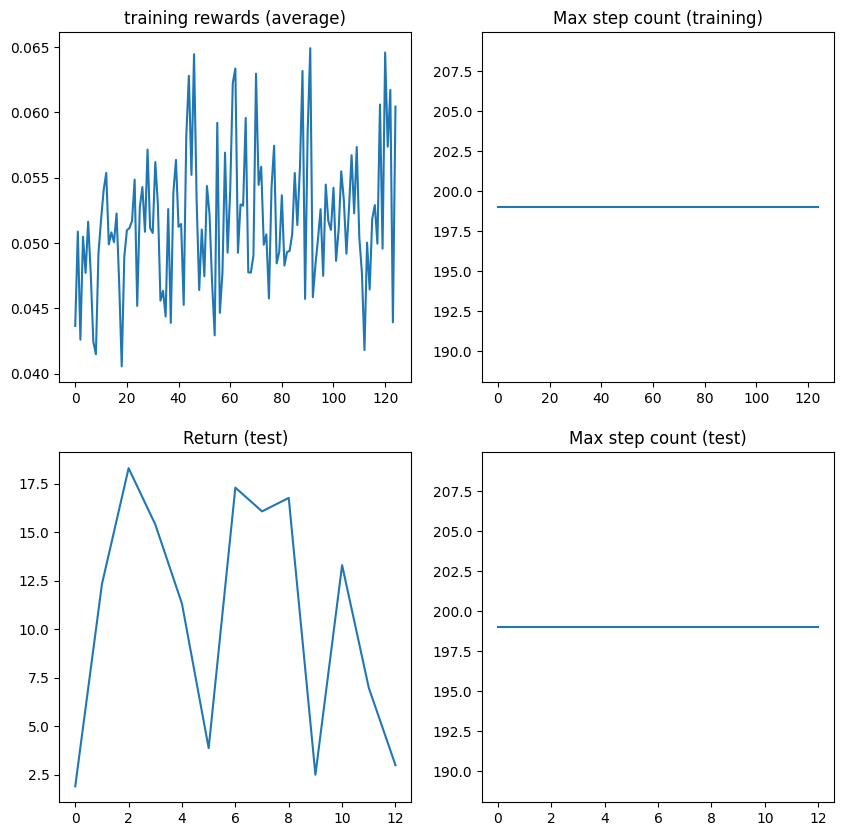

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [16]:
import re

#Visualise with video
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', s)]


print(sorted(os.listdir(VIDEO_DIR), key = natural_sort_key)[-1])
Video(VIDEO_DIR/sorted(os.listdir(VIDEO_DIR), key = natural_sort_key)[-1], embed = True)

only_video_13.mp4


### Further resources

How to debug your RL Model: https://pytorch.org/rl/main/reference/generated/knowledge_base/DEBUGGING_RL.html